In [5]:
## Load Dataframe
import pandas as pd
import plotly.express as px
import warnings
import fnmatch
import os

pd.set_option('future.no_silent_downcasting', True)

def loadPrometheusData(root, fileRegex, metricsName, fileAggFunc, fileExtn, aggfunction):
    print("processing "+fileRegex+metricsName+'-'+fileAggFunc+'*'+fileExtn)
    df1 = loadDataFrameFromFileRegex(root, fileRegex+metricsName+'-'+fileAggFunc+'*'+fileExtn, metrics=metricsName+'_'+fileAggFunc)
    if(metricsName == 'task_queue_length'):
        df1.loc[df1['metrics_name'].str.contains('securiti-appliance-downloader-tasks-queue', regex=False), 'metrics'] = 'taskq_'+fileAggFunc
        df1.loc[df1['metrics_name'].str.contains('t-appliance-downloader-tasks-queue', regex=False), 'metrics'] = 'downloadq_'+fileAggFunc
        df1.loc[df1['metrics_name'].str.contains('securiti-appliance-linker', regex=False), 'metrics'] = 'linkerq_'+fileAggFunc

    if(metricsName == 'infra_access_latency'):
        df1.loc[df1['metrics_name'].str.contains('appliance_es_access_latency', regex=False), 'metrics'] = 'esLatency_'+fileAggFunc
        df1.loc[df1['metrics_name'].str.contains('appliance_postgres_access_latency', regex=False), 'metrics'] = 'pgLatency_'+fileAggFunc
        df1.loc[df1['metrics_name'].str.contains('appliance_redis_access_latency', regex=False), 'metrics'] = 'redisLatency_'+fileAggFunc

    df1['node_ip']=df1['node_ip'].fillna("master")
    df1 = df1.groupby(['appliance_id','ts', 'node_ip', 'metrics']).agg(value=('value', aggfunction)).reset_index()   
    df1['ts']=pd.to_datetime(df1['ts'],unit='s')
    return df1[['appliance_id','ts', 'node_ip', 'metrics', 'value']] 

def loadDataFrameFromFileRegex(root, regex, **kwargs):
    metrics = kwargs.get('metrics', None)
    df_arr = []
    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch.fnmatch(name, regex) and os.path.getsize(os.path.join(path, name)) > 0:
                # print(os.path.join(path, name))
                df = pd.read_csv(os.path.join(path, name))
                df.insert(1, 'metrics', metrics)
                df_arr.append(df)
    if not df_arr:
        warnings.warn("No matching file found in "+root+" for regex: "+regex+". Empty dataframe will be returned." )
        return pd.DataFrame()    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)      
        return pd.concat(df_arr, ignore_index=True)

In [32]:
root = 'dataDir'
filePrefix = 'securiti_appliance_'
fileExtn = '.csv'

# metricsArr = ['infra_access_latency']
metricsArr = ['cpu_used', 'download_workers_count', 'memory_used', 'task_queue_length']
#'infra_access_latency', 'pod_cpu_usage', 'pod_memory_usage',
df_arr = []
for metricsName in metricsArr:
    for fileAggFunc in ['max', 'avg']:
        aggfunction = 'mean'
        if(fileAggFunc == 'max'):
            aggfunction = 'max'
        df_tmp = loadPrometheusData(root, filePrefix, metricsName, fileAggFunc, fileExtn, aggfunction)
        df_arr.append(df_tmp)

df = pd.concat(df_arr, ignore_index=True)

print("loading Unstrctured Data from file")
df9 = loadDataFrameFromFileRegex(root, 'UNSTRUCTURED-*.csv', metrics='dataScanned')
df9.rename(columns={'pod':'appliance_id'}, inplace=True)
df9['node_ip']="master"
df9=df9.groupby(['appliance_id', 'ts', 'node_ip']).agg(\
    dataScanned=('dataScannedInGB', 'sum'), \
    scanTime=('processingTimeinHrs', 'sum'), \
    numFilesScanned=('numberOfFilesScanned', 'sum'), \
    scannerIdleTime=('IdleTimeInHrs', 'sum'), \
    uniqPodCount=('uniqPodCount', 'max')).reset_index()
df9['ts']=pd.to_datetime(df9['ts'],unit='ms')
df9['avgFileSizeInMB']=df9['dataScanned']*1000/df9['numFilesScanned']
df9 = pd.melt(df9, id_vars=['appliance_id','ts', 'node_ip'], var_name='metrics', value_name='value')
df = pd.concat([df,df9], ignore_index=True)

display(df)


processing securiti_appliance_cpu_used-max*.csv
processing securiti_appliance_cpu_used-avg*.csv
processing securiti_appliance_download_workers_count-max*.csv
processing securiti_appliance_download_workers_count-avg*.csv
processing securiti_appliance_memory_used-max*.csv
processing securiti_appliance_memory_used-avg*.csv
processing securiti_appliance_task_queue_length-max*.csv
processing securiti_appliance_task_queue_length-avg*.csv
loading Unstrctured Data from file


,appliance_id,ts,node_ip,metrics,value
0,01c75278-9c0d-41be-b693-c970b18dbedc,2024-08-05 00:00:00,172.30.9.153,cpu_used_max,18.09
1,01c75278-9c0d-41be-b693-c970b18dbedc,2024-08-05 00:00:00,172.30.9.154,cpu_used_max,7.43
2,01c75278-9c0d-41be-b693-c970b18dbedc,2024-08-05 00:00:00,172.30.9.156,cpu_used_max,6.68
3,01c75278-9c0d-41be-b693-c970b18dbedc,2024-08-05 00:00:00,172.30.9.157,cpu_used_max,29.75
4,01c75278-9c0d-41be-b693-c970b18dbedc,2024-08-05 01:00:00,172.30.9.153,cpu_used_max,18.09
...,...,...,...,...,...
1801428,fea762bd-8e26-45da-b2ad-991722a2eb72,2024-08-03 18:00:00,master,avgFileSizeInMB,0.628271
1801429,ff215ba8-f310-4a13-a41d-a83e94026aa6,2024-08-06 03:00:00,master,avgFileSizeInMB,11.643209
1801430,ff215ba8-f310-4a13-a41d-a83e94026aa6,2024-08-06 04:00:00,master,avgFileSizeInMB,0.624196
1801431,ff215ba8-f310-4a13-a41d-a83e94026aa6,2024-08-07 07:00:00,master,avgFileSizeInMB,0.138147


In [51]:
fromDt = '2024-08-04'
toDt = '2024-08-19'
dfds = df[(df['metrics'] == 'dataScanned') & (df['ts'] >= fromDt) & (df['ts'] <= toDt) ]
dfds = dfds.groupby('appliance_id').agg(value=('value', 'sum')).reset_index().sort_values('value', ascending=False)
print(dfds.to_string())

                            appliance_id        value
28  4e8516b7-c73e-4c8d-9785-b255e37d1f0a  7080.781501
4   0af83074-d88b-4990-b033-92f28b161d2c  7033.103136
69  bd8883f2-5fbe-4891-aa64-7af60e2766fd  5949.165605
25  408b37cf-7e71-4d8f-ad4b-c6496d0739d6  5060.916323
2   055a16f1-e641-4703-a5d6-9119e8c60a6a  4540.322802
94  f5e5dfcf-9a14-47d8-b993-c5801e7380cb  3128.569821
42  72ea2f44-5ee8-410b-b798-a1d1f159bbe9  3120.723631
73  c723c866-7d3e-4782-a6d3-254731d3f3bc  2035.107553
41  713ffd72-b85f-4138-a477-9624a5fd64a5  2022.554407
24  3b430212-ef27-42c3-9e2c-1ffba99f2bdb  1488.994738
89  eb9e6e28-b2d3-4449-be41-661c315084f9  1412.672415
9   0fb7416b-dce9-4129-a02f-ebbc90ea18a9  1377.317241
93  f4363ae1-7639-466b-adb3-5c6ba1e84660  1370.304587
10  10eb2288-8d3b-4118-9a1a-f8b33b5c0770  1210.121335
44  781e2b69-d7e4-4b6f-b935-ccba26e3e671   1191.23212
92  f13a3fd0-b648-43e8-a3f7-44205d533a97  1007.320745
23  396254dc-3d6c-45e8-8a2b-0fd8d956a704   906.592644
21  37286f5a-9f8d-4f05-829a-

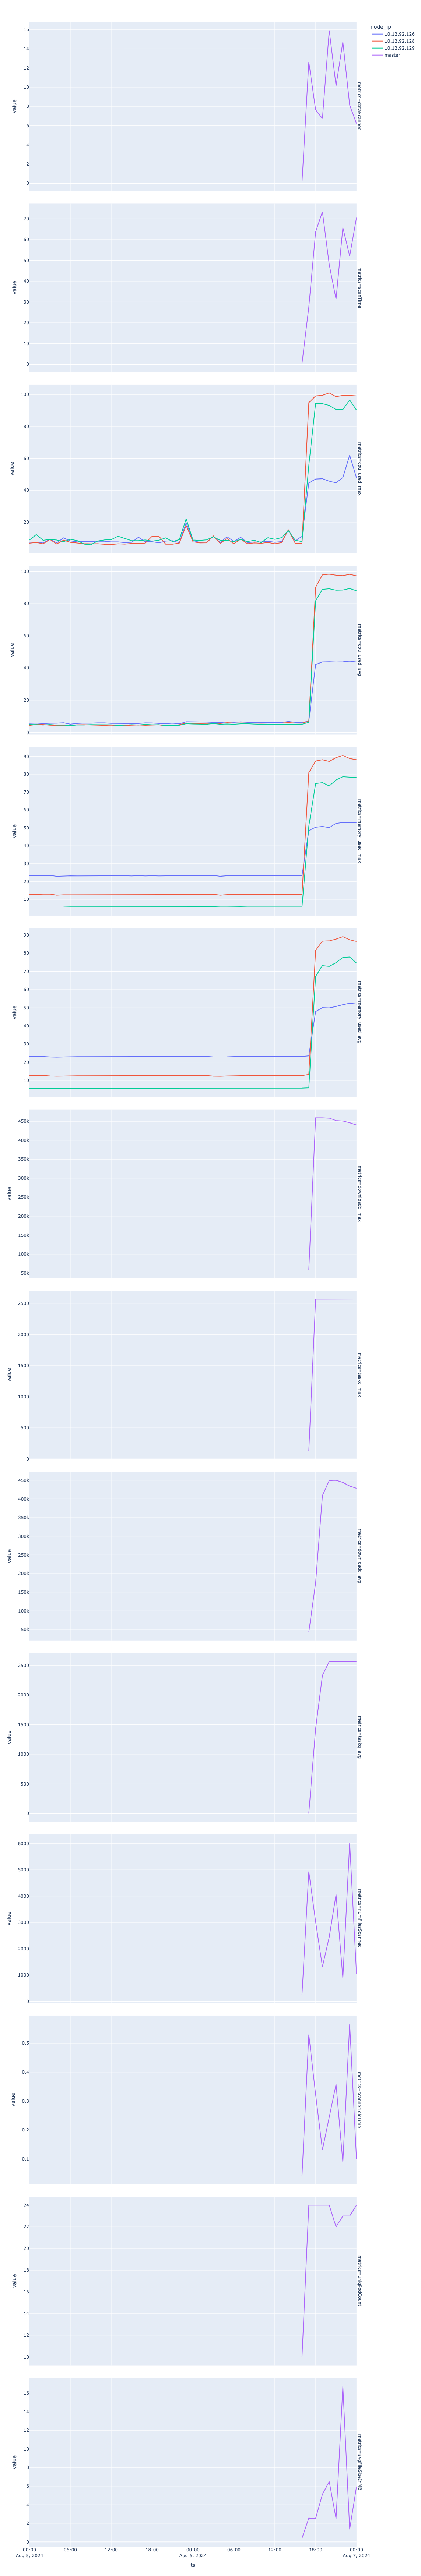

In [47]:
appliance_id = '0af83074-d88b-4990-b033-92f28b161d2c'
fromDt = '2024-08-05'
toDt = '2024-08-07'
dfp = df[(df['appliance_id'] == appliance_id) & (df['ts'] >= fromDt) & (df['ts'] <= toDt) ]
fig = px.line(dfp, x="ts", y="value", color='node_ip', facet_row='metrics', height=7000, facet_row_spacing=0.005, \
                            category_orders={"metrics": ["dataScanned", "scanTime"]})
fig = fig.update_yaxes(matches=None)
fig.show()

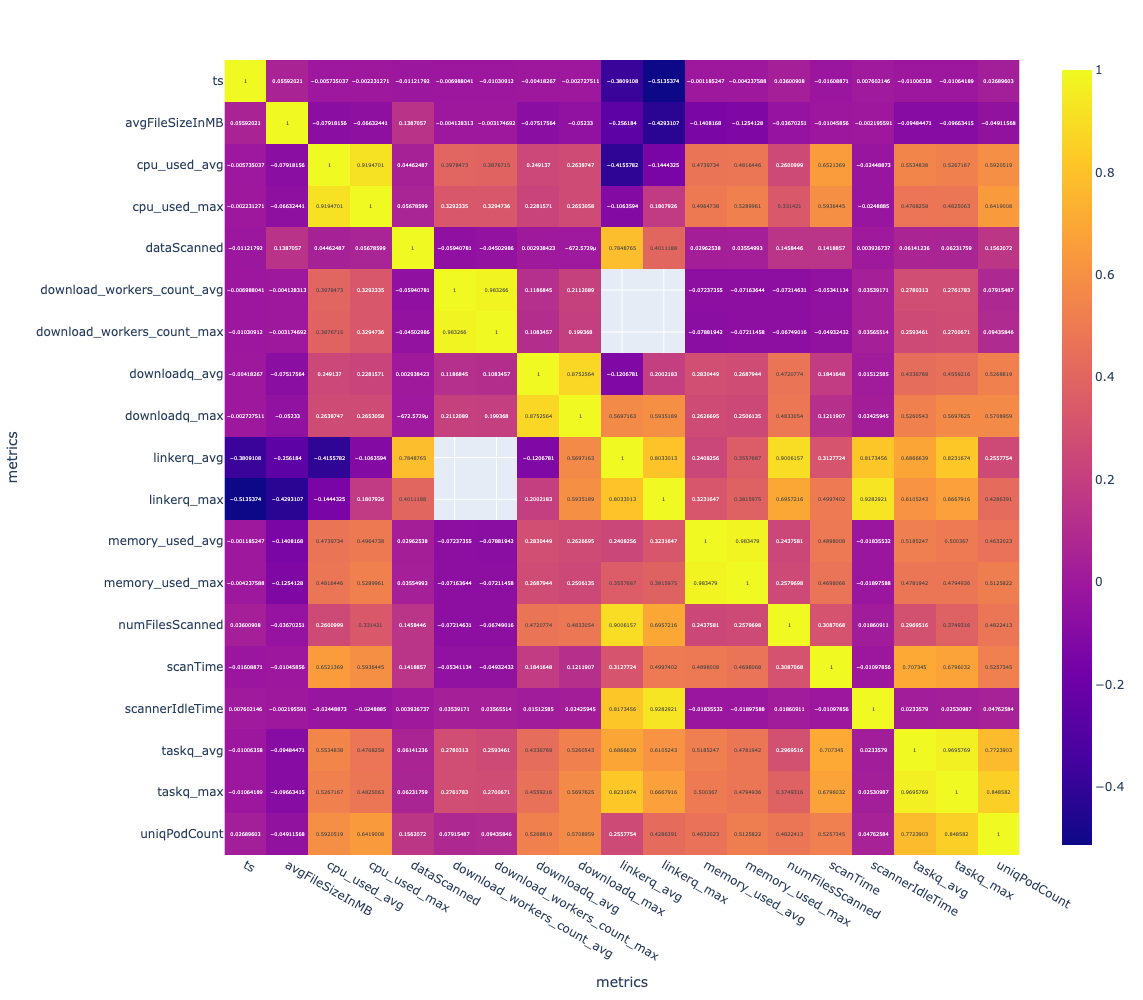

In [46]:
appliance_id = '37286f5a-9f8d-4f05-829a-2e9a8f25c5e4'
fromDt = '2024-08-04'
toDt = '2024-08-06'
dfp = df[(df['appliance_id'] == appliance_id) & (df['ts'] >= fromDt) & (df['ts'] <= toDt) ]
dfc = df.pivot_table(index=['appliance_id','ts'], columns='metrics', values='value', aggfunc='max').reset_index()
dfc.drop('appliance_id', axis=1, inplace=True)
dfc = dfc.corr()
fig1 = px.imshow(dfc, text_auto=True, height=1000)
fig1.show()